In [118]:
"""
reference:
https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb

https://medium.com/swlh/one-shot-learning-with-siamese-network-1c7404c35fda
"""

import random
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as vutils

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets as dset
from matplotlib import pyplot as plt


In [119]:
batch_size = 1
epochs = 20
learing_rate = 0.0001
triple_loss_mode = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [120]:
class FaceDatasets(Dataset):
    def __init__(self, root_dir: str, archor=False, train=True, transforms=None) -> None:
        super(FaceDatasets, self).__init__()
        self.root_dir = root_dir + ('train' if train else 'test')
        self.train = train
        self.archor = archor
        self.transforms = transforms
        self.data = dset.ImageFolder(self.root_dir).imgs
        
    def __getitem__(self, index):        
        # archor image
        if self.archor is True:
            archor_img = random.choice(self.data)
            positive_img = negative_img = None
            # postive image
            while True:
                img = random.choice(self.data)
                if archor_img[0] == img[0]:
                    continue
                
                if archor_img[1] == img[1]:
                    positive_img = img
                else:
                    negative_img = img
                    
                if positive_img and negative_img:
                    break
            

            a = cv2.imread(archor_img[0])
            p = cv2.imread(positive_img[0])
            n = cv2.imread(negative_img[0])
            
            a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
            p = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
            n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
            
            if self.transforms:
                a = self.transforms(a)
                p = self.transforms(p)
                n = self.transforms(n)
                
            return a, p, n
            
                
        else:                               
            face1 = random.choice(self.data)
            get_same_class = random.randint(0, 1)
            if get_same_class:
                while True:
                    face2 = random.choice(self.data)
                    if face1[1] == face2[1]:
                        break
            else:
                while True:
                    face2 = random.choice(self.data)
                    if face1[1] != face2[1]:
                        break
        
            is_same_face = int(face1[1] == face2[1])
            img1 = cv2.imread(face1[0])
            img2 = cv2.imread(face2[0])
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            
            if self.transforms:
                img1 = self.transforms(img1)
                img2 = self.transforms(img2)
                            
            return img1, img2, torch.from_numpy(np.array([is_same_face], dtype=np.float32))
    
    def __len__(self) -> int:
        return len(self.data)

In [121]:
train_face_datasets = FaceDatasets(root_dir='./dataset/', archor=triple_loss_mode, train=True, transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100)),
    # transforms.RandomHorizontalFlip()
]))

test_face_datasets = FaceDatasets(root_dir='./dataset/', archor=triple_loss_mode, train=False, transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100)),
    # transforms.RandomHorizontalFlip()
]))


train_face_dataloader = DataLoader(dataset=train_face_datasets, batch_size=batch_size, shuffle=True)
test_face_dataloader = DataLoader(dataset=test_face_datasets, batch_size=1, shuffle=True)


In [122]:
def plot_tensor_images(images, text=None):
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.axis('off')
    plt.imshow(np.transpose(images.numpy(), (1, 2, 0)))
    plt.show()
    

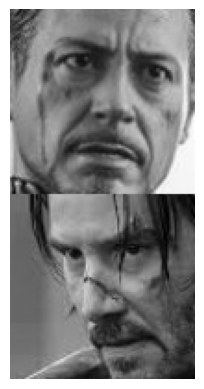

In [160]:
samples = iter(train_face_dataloader)
batch_data = next(samples)
concated = torch.cat(batch_data, 2) if triple_loss_mode else torch.cat((batch_data[0], batch_data[1]), 2)

plot_tensor_images(vutils.make_grid(concated, padding=2, normalize=True))

In [124]:
class SiamesesNetowrk(nn.Module):
    def __init__(self) -> None:
        super(SiamesesNetowrk, self).__init__()
        # input: 100 x 100
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.relu1 = nn.ReLU(inplace=True)
        self.batchNorm1 = nn.BatchNorm2d(64)
        # output: 64 x 50 x 50
        
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.relu2 = nn.ReLU(inplace=True)
        self.batchNorm2 = nn.BatchNorm2d(128)
        # ouput: 128 x 25 x 25
        
        self.conv3 = nn.Conv2d(128, 256, 3, 2, 1)
        self.relu3 = nn.ReLU(inplace=True)
        self.batchNorm3 = nn.BatchNorm2d(256)
        # ouput: 256 x 13 x 13
        
        self.conv4 = nn.Conv2d(256, 512, 3, 2)
        self.relu4 = nn.ReLU(inplace=True)
        self.batchNorm4 = nn.BatchNorm2d(512)
        # ouput: 512 x 6 x 6
        
        self.fc = nn.Sequential(
            nn.Linear(512*6*6, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1)
        )
        
    def forward_once(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batchNorm1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchNorm2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.batchNorm4(x)        
        
        x = x.reshape(x.size(0), -1)
        output = self.fc(x)

        return output
    
    def forward(self, x1: torch.Tensor, x2: torch.Tensor, x3: torch.Tensor):            
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        
        if triple_loss_mode:
            archor = self.forward_once(x3)
            positive = output1
            negative = output2
            return archor, positive, negative
        

        return  output1, output2
                

In [125]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2) -> None:
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, x1: torch.Tensor, x2: torch.Tensor, label: int):
        euclidean_distance = torch.nn.functional.pairwise_distance(x1, x2)
        loss = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2) + 
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )


        return loss
    

class TripletLoss(nn.Module):
    def __init__(self, margin=0.5) -> None:
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, a: torch.Tensor, p: torch.TensorType, n: torch.Tensor):
        euclidean_distance_postive = torch.nn.functional.pairwise_distance(a, p, keepdim=True)
        euclidean_distance_negative = torch.nn.functional.pairwise_distance(a, n, keepdim=True)
        loss = torch.mean(
            torch.clamp(euclidean_distance_postive - euclidean_distance_negative + self.margin, min=0.0)
        )
        return loss
        
        

In [126]:
model = SiamesesNetowrk().to(device)
criterion =torch.nn.TripletMarginWithDistanceLoss() if triple_loss_mode else ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learing_rate)

In [127]:
iter_num = 0
losses = []
loop = []

for epoch in range(epochs):
    for idx, data in enumerate(train_face_dataloader):

        
        optimizer.zero_grad()
        
        if triple_loss_mode:
            archor_img = data[0].to(device)
            postive_img = data[1].to(device)
            negative_img = data[2].to(device)
            
            archor, positive, negative = model(postive_img, negative_img, archor_img)
            loss = criterion(archor, positive, negative)
        else:     
            img1 = data[0].to(device)
            img2 = data[1].to(device)
            label = data[2].to(device)
            
            output1, output2 = model(img1, img2, None)
            loss = criterion(output1, output2, label)
        
        loss.backward()
        
        optimizer.step()
        
        if (idx % 10) == 0:
            print(f"Epochs {epoch+1} / {epochs}, loss {loss.item()}")
            
        iter_num += 1
        loop.append(iter_num)
        losses.append(loss.item())

Epochs 1 / 20, loss 5.15323745275964e-06
Epochs 2 / 20, loss 0.0
Epochs 3 / 20, loss 3.9452381134033203
Epochs 4 / 20, loss 3.9999961853027344
Epochs 5 / 20, loss 0.0
Epochs 6 / 20, loss 3.9999961853027344
Epochs 7 / 20, loss 5.80539083480835
Epochs 8 / 20, loss 3.865302562713623
Epochs 9 / 20, loss 1.5552669763565063
Epochs 10 / 20, loss 4.692847728729248
Epochs 11 / 20, loss 11.887985229492188
Epochs 12 / 20, loss 2.4000768661499023
Epochs 13 / 20, loss 0.7334203720092773
Epochs 14 / 20, loss 0.09302673488855362
Epochs 15 / 20, loss 0.021935945376753807
Epochs 16 / 20, loss 0.0018134670099243522
Epochs 17 / 20, loss 2.4091334342956543
Epochs 18 / 20, loss 4.477596759796143
Epochs 19 / 20, loss 2.025434732437134
Epochs 20 / 20, loss 3.6684563159942627


Text(0, 0.5, 'loss')

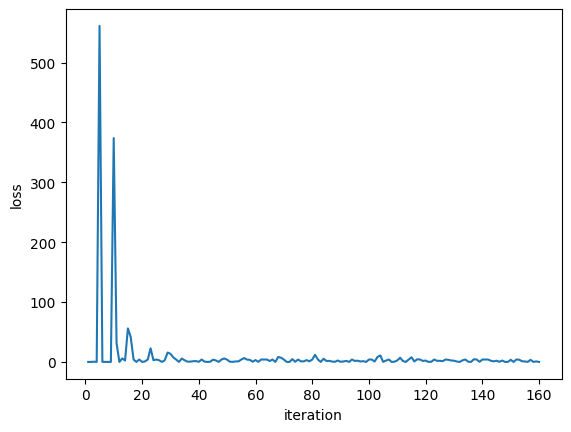

In [128]:
plt.plot(loop, losses)
plt.xlabel('iteration')
plt.ylabel('loss')

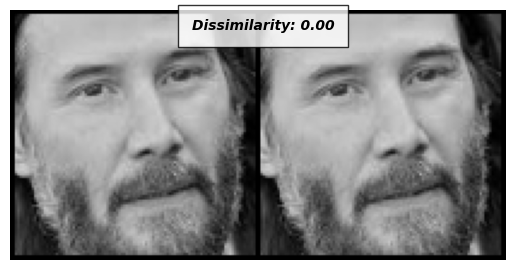

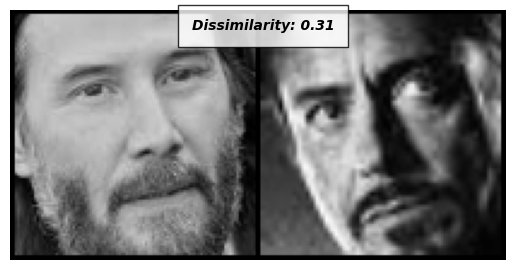

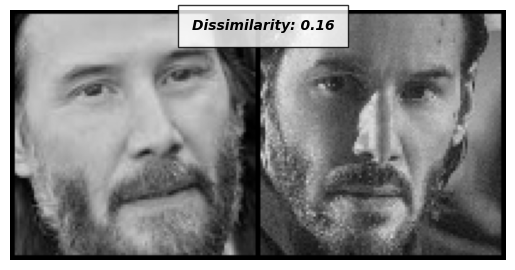

In [150]:
test_sampels = iter(test_face_dataloader)

if triple_loss_mode:
    for i in range(len(test_sampels)):
        data = next(test_sampels)
        archor_img = data[0].to(device)
        postive_img = data[1].to(device)
        negative_img = data[2].to(device)
        
        concated = torch.cat((archor_img, postive_img, negative_img), 0)
        archor, positive, negative = model(postive_img, negative_img, archor_img)
        
        postive_dist = torch.nn.functional.pairwise_distance(archor, positive)
        negative_dist = torch.nn.functional.pairwise_distance(archor, negative)
        
        plot_tensor_images(torchvision.utils.make_grid(concated),'Dissimilarity: P-{:.2f}, N-{:.2f}'.format(postive_dist.item(), negative_dist.item()))
else:
    x0, _, _ = next(test_sampels)
    x0 = x0.to(device)
    for i in range(len(test_sampels) - 1):
        _, x1, label = next(test_sampels)
        x1 = x1.to(device)
        label = label.to(device)
        
        concated = torch.cat((x0, x1), 0)
        output1, output2 = model(x0, x1, None)
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        plot_tensor_images(torchvision.utils.make_grid(concated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    